# Nilearn

If you're working on NeuroImaging data, you should check another Python library, **Nilearn**, that is design for  fast and easy statistical learning on NeuroImaging data. It leverages the scikit-learn Python toolbox for multivariate statistics with applications such as predictive modeling, classification, decoding, or connectivity analysis. Use their [website](http://nilearn.github.io/) to find out more.

As an example of how to use Nilearn, we will use the Haxby 2001 study on a face vs cat discrimination task in a mask of the ventral stream. This part is based on a [Nilearn tutorial](https://nilearn.github.io/auto_examples/plot_decoding_tutorial.html).

**Note** that first time you fetch the data, it can take a few minutes.

## Downloading data

In [1]:
from nilearn import datasets

# By default 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby()

We can access anatomical, functional and mask data. And in addition we have true labels.

In [2]:
func_file = haxby_dataset.func[0]
mask_file = haxby_dataset.mask_vt[0]
anat_file = haxby_dataset.anat[0]
labels_file = haxby_dataset.session_target[0]

let's get some info about ``bold`` file:

In [3]:
!nib-ls $func_file

/home/neuro/nilearn_data/haxby2001/subj2/bold.nii.gz int16 [ 40,  64,  64, 1452] 3.50x3.75x3.75x2.50   sform



## Convert the fMRI volume’s to a data matrix using masks

We need our functional data in a 2D, sample-by-voxel matrix. To get that, we'll select a set of voxels in Ventral Temporal cortex defined by mask from the Haxby study:

/opt/conda/envs/neuro/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


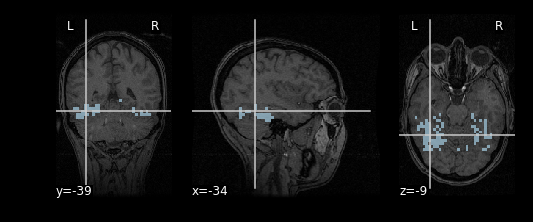

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from nilearn import plotting
plotting.plot_roi(mask_file, anat_file, cmap='Paired', dim=-.5)

Now we will create masker using the ``NiftiMasker``. ``NiftiMasker`` is an object that applies a mask to a dataset and returns the masked voxels as a vector at each time point. Here we use ``standardizing=True`` the time-series are centered and normed.

In [5]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask_file, standardize=True)

# We give the masker a filename and retrieve a 2D array ready
# for machine learning with scikit-learn
fmri_masked = masker.fit_transform(func_file)

``fmr_mask`` is a NumPy array and its shape corresponds to the number of time-points times the number of voxels in the mask.

In [6]:
print(fmri_masked.shape)

(1452, 464)


To recover the original data shape (giving us a masked and z-scored BOLD series), you can use ``masker.inverse_transform``.

##  Load the behavioral labels and choosing conditions

The ``label_file`` is CSV file, we can read it using NumPy:

In [7]:
labels =  np.recfromcsv(labels_file, delimiter=" ")
labels

rec.array([(b'rest',  0), (b'rest',  0), (b'rest',  0), ..., (b'rest', 11),
           (b'rest', 11), (b'rest', 11)], 
          dtype=[('labels', 'S12'), ('chunks', '<i8')])

It's an array that have ``labels`` that gives information about condition and chunks represents a run number. We will use conditions: 

In [8]:
conditions = labels['labels']
np.unique(conditions)

array([b'bottle', b'cat', b'chair', b'face', b'house', b'rest',
       b'scissors', b'scrambledpix', b'shoe'],
      dtype='|S12')

We see that there are 9 different conditions, but we will use faces and cats only. Let's create another mask (this time masking the time points) that we will apply to our ``fmri_mask``

In [9]:
condition_mask = np.logical_or(conditions == b'face', conditions == b'cat')
conditions_2lb = conditions[condition_mask]
fmri_masked_2lb = fmri_masked[condition_mask]
print(fmri_masked_2lb.shape)

(216, 464)


## Decoding with an SVM

Now we will use a learning algorithm from scikit-learn to apply to our neuroImaging data. We will use a [Support Vector Classification](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), with a linear kernel.

In [10]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')

Let's split our data and fit the model using the training set:

In [11]:
from sklearn.model_selection import train_test_split
fmri_tr, fmri_ts, cond_tr, cond_ts = train_test_split(fmri_masked_2lb, conditions_2lb)
svc.fit(fmri_tr, cond_tr)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

And we can check the score for the testing set:

In [12]:
svc.score(fmri_ts, cond_ts)

1.0

### Exercise 1

Validate the model using ``cross_val_score``, try different kernels for SVM.

Run ``cross_val_score`` for ``SVC`` linear kernel:

In [13]:
from sklearn.model_selection import cross_val_score, LeaveOneOut

svc_ln = SVC(kernel='linear')
scores = cross_val_score(svc_ln, fmri_masked_2lb, conditions_2lb, cv=LeaveOneOut())
print("Linear kernel: scores = {}, mean score = {:03.2f}".format(scores, scores.mean()))

Linear kernel: scores = [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.
  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.
  1.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  0.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.], mean score = 0.93


And now, let's try a default kernel

In [14]:
svc_rbf = SVC()
scores = cross_val_score(svc_rbf, fmri_masked_2lb, conditions_2lb, cv=LeaveOneOut())
print("Default rbf kernel: scores = {}, mean score = {:03.2f}".format(scores, scores.mean()))

Default rbf kernel: scores = [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  1.  0.  1.  0.], mean score = 0.93


In [15]:
# write your solution here

# 1. read about available kernels http://scikit-learn.org/stable/modules/svm.html and initialize models with two different kernels

# 2. run cross_val_score for both models and compare the results

### Exercise 2

Check if ``KNeighborsClassifier`` would work for this dataset. Validate the model in the same way as SVC.

In [16]:
from sklearn.neighbors import KNeighborsClassifier
clf_kn = KNeighborsClassifier()

scores = cross_val_score(clf_kn, fmri_masked_2lb, conditions_2lb, cv=LeaveOneOut())
print("Scores: {}, mean score = {:03.2f}".format(scores, scores.mean()))

Scores: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.], mean score = 0.95


As we can see, this model also works pretty well for the dataset.

In [17]:
# write your solution here

# 1. initialize  KNeighborsClassifier (you can change the default arguments)

# 2. run cross_val_score

We can check weights assigned to the features by the model:

In [18]:
coef = svc.coef_
print(coef)

[[ -6.66092940e-02  -1.14664454e-02  -1.97769182e-02  -3.04724624e-02
    1.53187515e-02   6.28550982e-03   7.83290001e-03  -8.12416516e-02
    1.57173128e-02  -5.20420111e-02  -7.35369434e-03  -1.00199015e-02
   -2.30872973e-02  -4.37551427e-02  -3.14713848e-02  -3.82188263e-04
    4.13592361e-03  -1.20209509e-02  -7.98476207e-04  -2.89294506e-02
    4.50636049e-02  -4.95792799e-02  -6.37967127e-02   1.27540192e-02
    3.08607109e-02   8.38984690e-03  -2.84729729e-02  -9.08582416e-03
   -3.25462769e-02   4.84650435e-02   2.65477129e-02  -6.03446888e-02
    2.21949168e-02  -2.66166702e-02   4.37225208e-03  -3.68251458e-02
    2.36926896e-02  -8.63238170e-03  -1.12463147e-02  -2.66835631e-02
   -1.12645053e-01   4.32792123e-02   1.91639841e-02  -4.16300764e-04
   -2.09639050e-02   1.74558139e-02  -4.66711437e-03   4.43542561e-02
   -2.92823793e-02   2.80123631e-02   3.92462613e-02  -1.07184601e-02
    2.85507711e-02   2.55060524e-02  -5.14979160e-02  -8.37271812e-03
   -8.99568377e-03  

Our array should have the same size as the VT mask:

In [19]:
coef.shape

(1, 464)

We need to turn it back into an original Nifti image, in essence, “inverting” what the NiftiMasker has done. For this, we can call ``inverse_transform`` on the ``NiftiMasker``:

In [20]:
coef_img = masker.inverse_transform(coef)
print(coef_img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (40, 64, 64, 1)
affine: 
[[  -3.5      0.       0.      68.25 ]
 [   0.       3.75     0.    -118.125]
 [   0.       0.       3.75  -118.125]
 [   0.       0.       0.       1.   ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 4 40 64 64  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.    3.5   3.75  3.75  1.    1.    1.    1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_f

If we need, we can save the image:

In [21]:
coef_img.to_filename('haxby_svc_weights.nii.gz')

## Plotting the SVM weights

Now, lets plot our weights on top of the anatomical image:

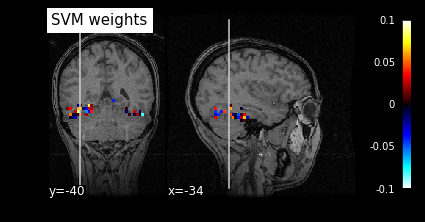

In [22]:
from nilearn.plotting import plot_stat_map

plot_stat_map(coef_img, anat_file, vmax=0.1, dim=-1,
              title="SVM weights", display_mode="yx")

Now you can see which area in VT cortex are important to distinguish between the two conditions according to our model.

### Exercise 3

Try to run model using all conditions (except rest state). This is multiclass classification, try one-vs-all and one-vs-one strategies (can read more [here](https://en.wikipedia.org/wiki/Multiclass_classification)), which one should be faster? 
Does the new model has as high score as the one with two conditions only? 

We will start from creating a new mask that removes only rest state.

In [23]:
conditions_new = conditions[conditions != b'rest']
fmri_masked_new = fmri_masked[conditions != b'rest']
fmri_masked_new.shape

(864, 464)

Running One-vs-one multiclass classification. Note, that this will take longer than last time, see the shape of our data.

In [24]:
from sklearn.model_selection import cross_val_score, LeaveOneOut

svc_new_ovo = SVC(kernel='linear', decision_function_shape="ovo")
scores = cross_val_score(svc_new_ovo, fmri_masked_new, conditions_new, cv=LeaveOneOut())
print("Scores: {}, mean score = {:03.2f}".format(scores, scores.mean()))

Scores: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.
  0.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.
  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

Let's try now one-vs-all now, it should be faster. 

In [25]:
svc_new_ovr = SVC(kernel='linear', decision_function_shape="ovr")
scores = cross_val_score(svc_new_ovr, fmri_masked_new, conditions_new, cv=LeaveOneOut())
print("Scores: {}, mean score = {:03.2f}".format(scores, scores.mean()))

Scores: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.
  0.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.
  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

Both methods give the same rusult.

In [26]:
# write your solution here

# 1. create a new mask and apply to conditions and fmri_masked

# 2. initialize SVC model with two different decision_function_shape; run cross_val_score and compare results

### Exercise 4
Using one of the models from previous exercise check which condition is the easiest to identify by the model and which one is the hardest?

Lets split manually for two sets and use the model with ovr from previous exercise.

In [27]:
fmri_new_tr, fmri_new_ts, cond_new_tr, cond_new_ts = train_test_split(fmri_masked_new, conditions_new)
svc_new_ovr.fit(fmri_new_tr, cond_new_tr)
cond_new_pred = svc_new_ovr.predict(fmri_new_ts)

Now we will create a dictionary and for every condition we will check how often the model identified it correctly: 

In [28]:
acc_cond = {}
for cn in np.unique(cond_new_ts):
    acc_cond[cn] = cond_new_pred[(cond_new_pred==cn) & (cond_new_ts==cn)].shape[0] / cond_new_ts[cond_new_ts==cn].shape[0]

print(acc_cond)

{b'bottle': 0.8636363636363636, b'cat': 0.8928571428571429, b'chair': 0.9583333333333334, b'face': 0.9642857142857143, b'house': 1.0, b'scissors': 0.8333333333333334, b'scrambledpix': 0.896551724137931, b'shoe': 0.8636363636363636}


Looks like house was the easiest for our model. 

In [29]:
# write your code here

# 1. split the data using train_test_split and fit the model using training data

# 2. run predict on testing data

# 3. for every condition calculate how often model identified it correctly